In [7]:
import pandas as pd
import h5py
import hdf5plugin
from datetime import datetime

# Path to UK-DALE HDF5 file
file_path = '/users/kjain/Downloads/ukdale.h5'

# Define a manual mapping of meters to appliances (Update if needed)
meter_mapping = {
    'meter1': 'Main Power',
    'meter10': 'Fridge',
    'meter11': 'Washing Machine',
    'meter12': 'Microwave',
    'meter13': 'Dishwasher'
}

# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    print("Keys:", list(hdf.keys())) # Check available buildings

    # Navigate to House 1's electricity data
    house_path = 'building1/elec'
    house_data = hdf[house_path]

    # List to store DataFrames for each meter
    meter_dfs = []

    # Process meters (select relevant meters based on mapping)
    for meter_id in meter_mapping.keys():
        meter_path = f"{house_path}/{meter_id}"

        if "table" in house_data[meter_id]:
            print(f"Processing {meter_id} ({meter_mapping[meter_id]})...")
            table_data = house_data[meter_id]['table']
            
            # Read data in chunks (optimized for memory usage)
            timestamps = []
            power_values = []

            for entry in table_data[:500000]: # Read only 500,000 entries at a time
                timestamp, power = entry
                timestamps.append(datetime.utcfromtimestamp(timestamp / 1e9)) # Convert nanoseconds
                power_values.append(power[0]) # Extract first power value

            # Create DataFrame
            df_meter = pd.DataFrame({'timestamp': timestamps, meter_mapping[meter_id]: power_values})

            # Append to list (we will merge later)
            meter_dfs.append(df_meter)

    # Merge all meter DataFrames on timestamp
    df = meter_dfs[0]
    for meter_df in meter_dfs[1:]:
        df = df.merge(meter_df, on='timestamp', how='outer') # Outer join to include all timestamps

    # Convert timestamp to DateTimeIndex
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # ✅ Filter for January 2013
    df_month = df.loc['2013-01-01':'2013-01-31']

    # Save to CSV
    df_month.to_csv('house1_january2013_some_appliances.csv')

print("✅ Data saved to house1_january2013_some_appliances.csv")

Keys: ['building1', 'building2', 'building3', 'building4', 'building5']
Processing meter1 (Main Power)...
Processing meter10 (Fridge)...
Processing meter11 (Washing Machine)...
Processing meter12 (Microwave)...
Processing meter13 (Dishwasher)...
✅ Data saved to house1_january2013_some_appliances.csv


In [6]:
import pandas as pd
# Load the CSV file
df = pd.read_csv('/Users/kjain/Project/house1_january2013_some_appliances.csv', parse_dates=['timestamp'], index_col='timestamp')

df.describe()


,Main Power,Fridge,Washing Machine,Microwave,Dishwasher
count,68632.000000,250970.000000,282877.000000,283848.000000,284564.000000
mean,483.778529,17.289397,16.156361,36.072845,7.212399
std,452.883201,192.713773,158.560277,51.482686,97.319706
min,162.000000,0.000000,0.000000,0.000000,0.000000
25%,240.000000,1.000000,0.000000,0.000000,1.000000
50%,384.000000,1.000000,0.000000,0.000000,1.000000
75%,530.000000,1.000000,0.000000,86.000000,1.000000
max,4651.000000,2596.000000,2803.000000,2178.000000,2898.000000


In [7]:
df.head()

,Main Power,Fridge,Washing Machine,Microwave,Dishwasher
timestamp,,,,,
2013-01-01 00:00:01,499.0,1.0,0.0,89.0,NaN
2013-01-01 00:00:02,NaN,NaN,NaN,NaN,1.0
2013-01-01 00:00:07,500.0,NaN,NaN,89.0,NaN
2013-01-01 00:00:08,NaN,1.0,0.0,NaN,1.0
2013-01-01 00:00:13,515.0,NaN,NaN,NaN,NaN


/var/folders/sj/1c1l30xn36dgw92bwyf1rn_w0000gp/T/ipykernel_3472/3615689760.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('1H').mean()


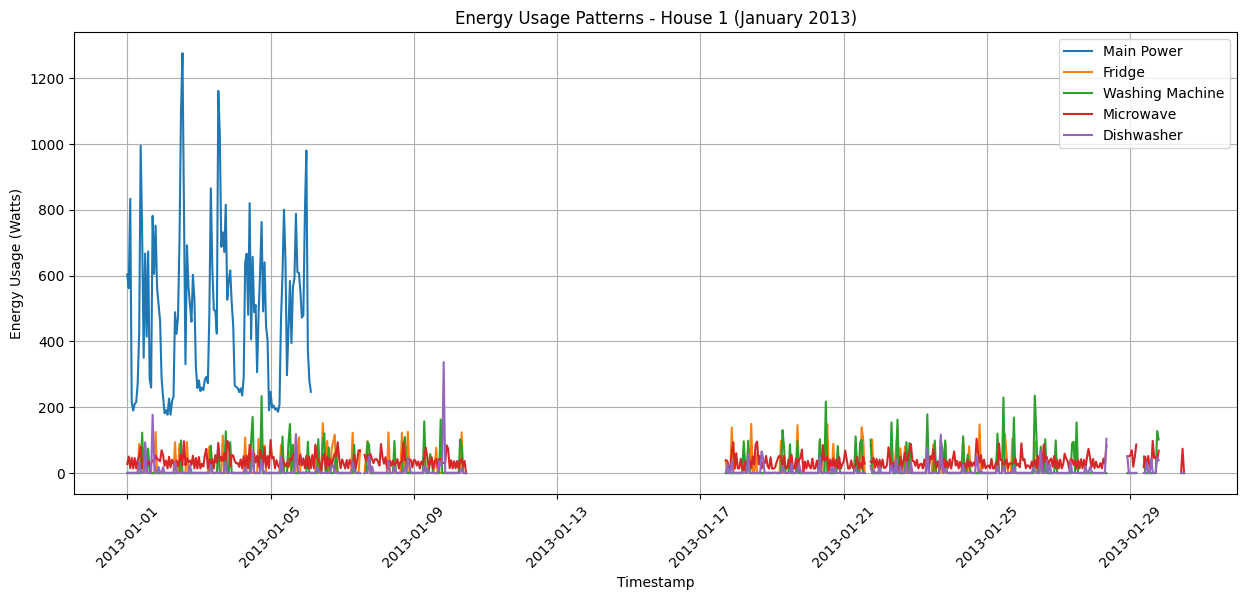

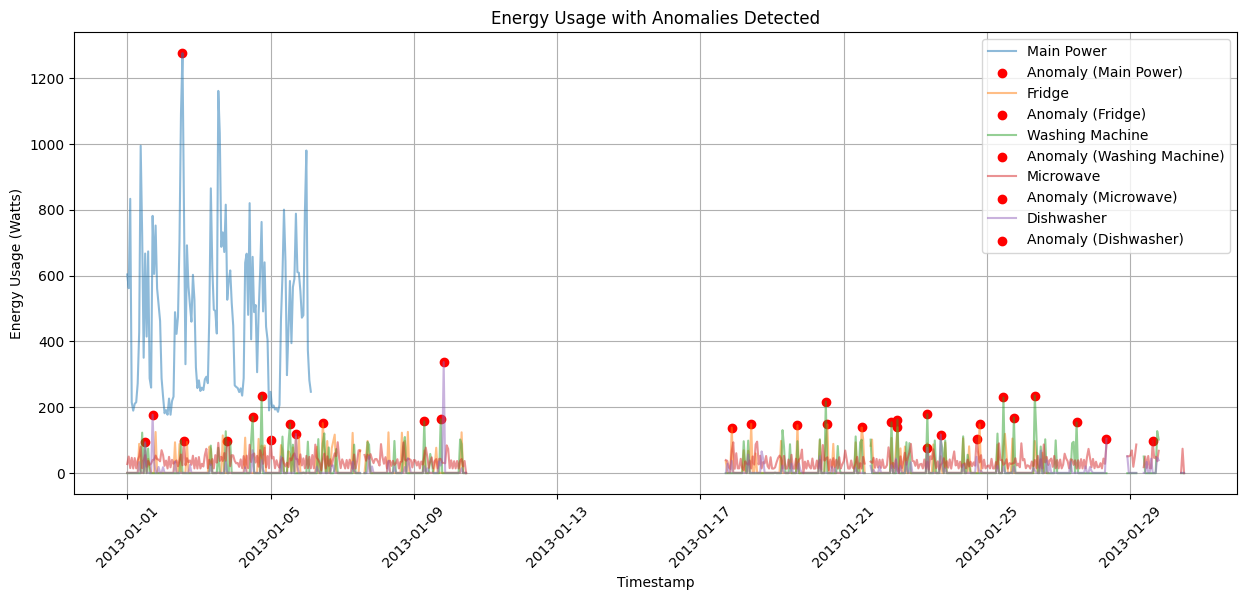


Anomalies in Main Power:
timestamp
2013-01-02 13:00:00    1275.611429
Freq: h, Name: Main Power, dtype: float64

Anomalies in Fridge:
timestamp
2013-01-06 11:00:00    152.005587
2013-01-17 21:00:00    138.516522
2013-01-18 10:00:00    149.360825
2013-01-19 17:00:00    145.594828
2013-01-20 13:00:00    148.276680
2013-01-21 12:00:00    138.814879
2013-01-22 12:00:00    139.234343
2013-01-24 19:00:00    148.313043
Name: Fridge, dtype: float64

Anomalies in Washing Machine:
timestamp
2013-01-04 12:00:00    170.839864
2013-01-04 18:00:00    234.133562
2013-01-05 13:00:00    149.340171
2013-01-09 07:00:00    157.309402
2013-01-09 18:00:00    163.209262
2013-01-20 12:00:00    217.593103
2013-01-22 08:00:00    154.342513
2013-01-22 12:00:00    162.614919
2013-01-23 08:00:00    178.597938
2013-01-25 11:00:00    229.868966
2013-01-25 18:00:00    169.027491
2013-01-26 08:00:00    235.674617
2013-01-27 12:00:00    153.955403
Name: Washing Machine, dtype: float64

Anomalies in Microwave:
timestam

In [8]:
import pandas as pd
import numpy as np
import hdf5plugin
import h5py
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/users/kjain/Project/house1_january2013_some_appliances.csv'
df = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')

# Resample data to hourly mean to reduce noise
df_resampled = df.resample('1H').mean()

# Plot Time Series Data
plt.figure(figsize=(15, 6))
for column in df_resampled.columns:
    plt.plot(df_resampled.index, df_resampled[column], label=column)

plt.xlabel('Timestamp')
plt.ylabel('Energy Usage (Watts)')
plt.title('Energy Usage Patterns - House 1 (January 2013)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# --- Anomaly Detection ---
# Define threshold using standard deviation
threshold = 3 # Adjust this if needed
mean_usage = df_resampled.mean()
std_dev = df_resampled.std()

# Identify anomalies (values beyond mean ± threshold * std deviation)
anomalies = ((df_resampled - mean_usage).abs() > (threshold * std_dev))

# Plot Anomalies
plt.figure(figsize=(15, 6))
for column in df_resampled.columns:
    plt.plot(df_resampled.index, df_resampled[column], label=column, alpha=0.5)
    anomaly_points = df_resampled[column][anomalies[column]]
    plt.scatter(anomaly_points.index, anomaly_points, color='red', label=f'Anomaly ({column})')

plt.xlabel('Timestamp')
plt.ylabel('Energy Usage (Watts)')
plt.title('Energy Usage with Anomalies Detected')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Print anomaly timestamps
for column in df_resampled.columns:
    print(f"\nAnomalies in {column}:")
    print(df_resampled[column][anomalies[column]].dropna())

Now using my own chatgpy response

/var/folders/sj/1c1l30xn36dgw92bwyf1rn_w0000gp/T/ipykernel_5221/577333534.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('1T').mean() # '1T' means per minute


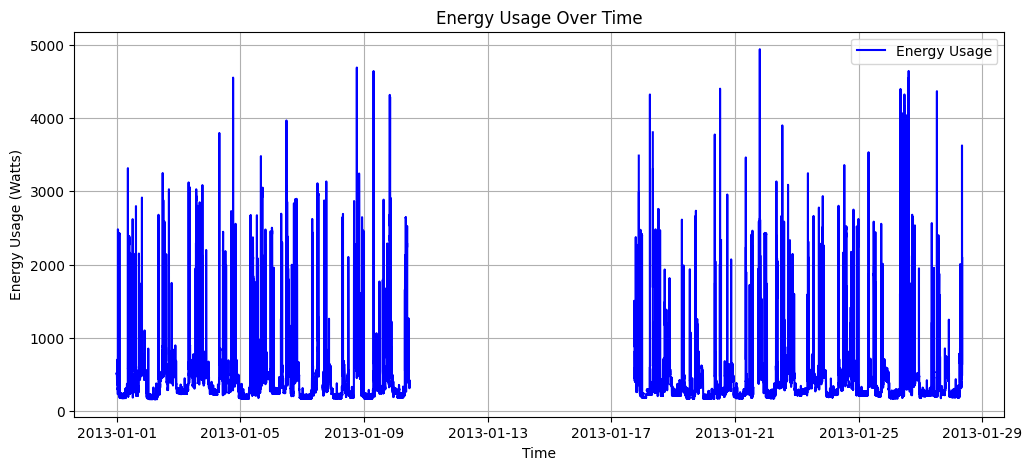

In [2]:
#Line Plot for Energy Usage Over Time


import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_path = "/Users/kjain/Project/house1_january2013.csv" # Update with your actual CSV file path
df = pd.read_csv(file_path)

# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample data to get per-minute average energy usage
df_resampled = df.resample('1T').mean() # '1T' means per minute

# Plot time-series line chart
plt.figure(figsize=(12, 5))
plt.plot(df_resampled, label="Energy Usage", color='b')
plt.xlabel("Time")
plt.ylabel("Energy Usage (Watts)")
plt.title("Energy Usage Over Time")
plt.legend()
plt.grid()
plt.show()

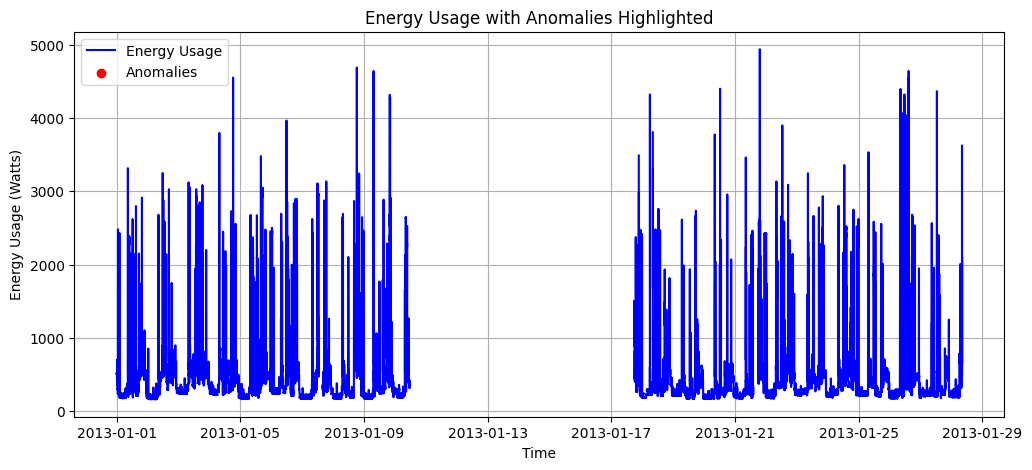

In [3]:
# Scatter Plot for Outlier Detection (Z-Score Method)

from scipy.stats import zscore

# Calculate Z-score
df_resampled['z_score'] = zscore(df_resampled['energy_usage'])

# Define anomaly threshold (Z-score > 3 or < -3)
anomalies = df_resampled[abs(df_resampled['z_score']) > 3]

# Scatter plot to highlight anomalies
plt.figure(figsize=(12, 5))
plt.plot(df_resampled['energy_usage'], label="Energy Usage", color='b')
plt.scatter(anomalies.index, anomalies['energy_usage'], color='r', label="Anomalies", marker='o')
plt.xlabel("Time")
plt.ylabel("Energy Usage (Watts)")
plt.title("Energy Usage with Anomalies Highlighted")
plt.legend()
plt.grid()
plt.show()

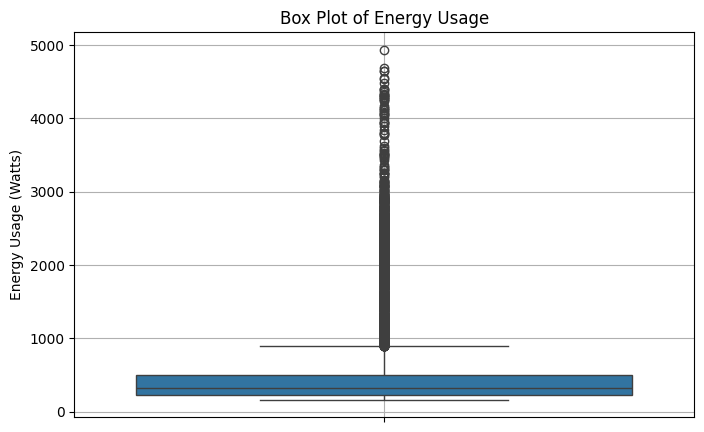

In [4]:
# Box Plot for Detecting Anomalies
import seaborn as sns

# Box plot for energy usage
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_resampled['energy_usage'])
plt.title("Box Plot of Energy Usage")
plt.ylabel("Energy Usage (Watts)")
plt.grid()
plt.show()

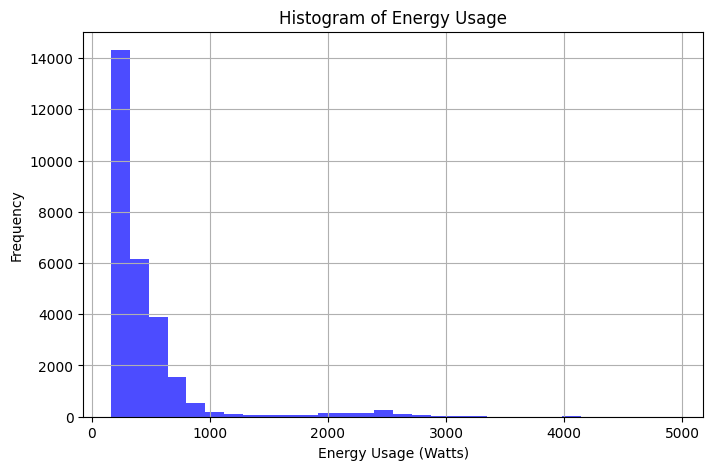

In [5]:
# Histogram for Energy Usage Distribution
plt.figure(figsize=(8, 5))
plt.hist(df_resampled['energy_usage'], bins=30, color='blue', alpha=0.7)
plt.xlabel("Energy Usage (Watts)")
plt.ylabel("Frequency")
plt.title("Histogram of Energy Usage")
plt.grid()
plt.show()

/var/folders/sj/1c1l30xn36dgw92bwyf1rn_w0000gp/T/ipykernel_5221/2325439959.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean() # Resample to hourly


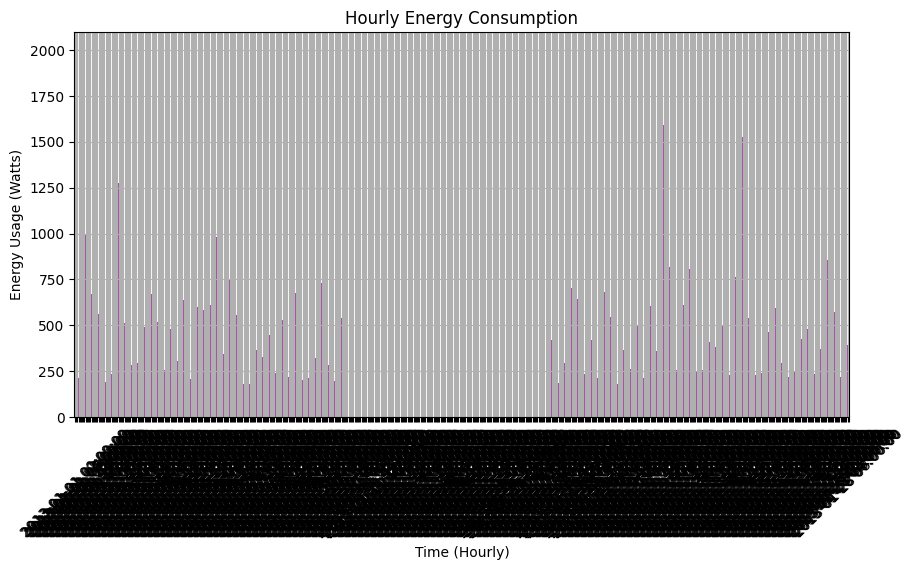

In [6]:
#  Bar Chart for Hourly Energy Consumption
df_hourly = df.resample('H').mean() # Resample to hourly

# Bar chart
plt.figure(figsize=(10, 5))
df_hourly['energy_usage'].plot(kind='bar', color='purple', alpha=0.7)
plt.xlabel("Time (Hourly)")
plt.ylabel("Energy Usage (Watts)")
plt.title("Hourly Energy Consumption")
plt.xticks(rotation=45)
plt.grid()
plt.show()

now using mac chatgpt on /Users/kjain/Project/house1_january2013_some_appliances.csv

In [3]:
%pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


/var/folders/sj/1c1l30xn36dgw92bwyf1rn_w0000gp/T/ipykernel_6283/216234445.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


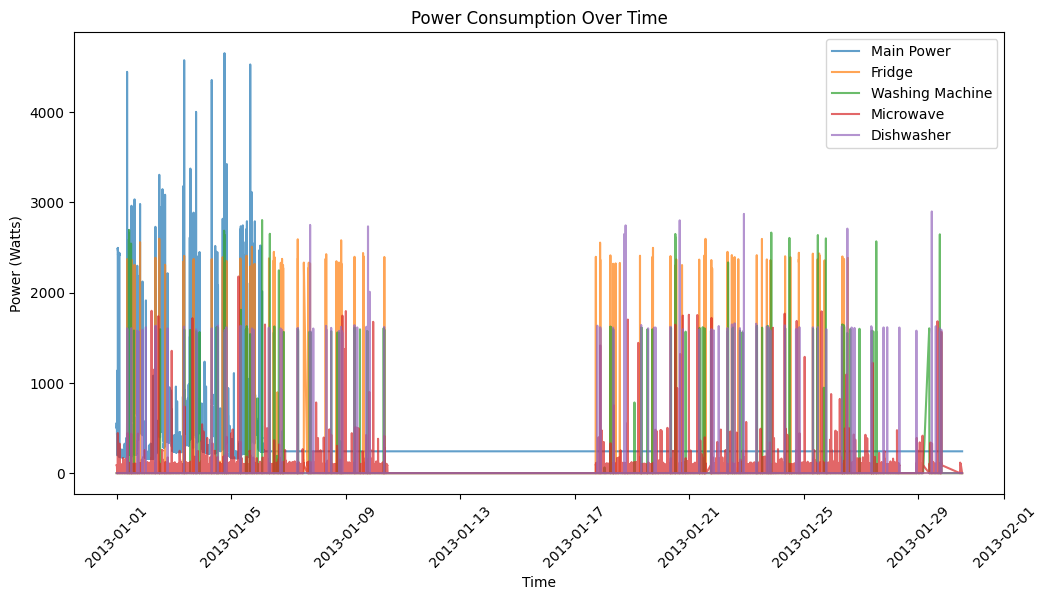

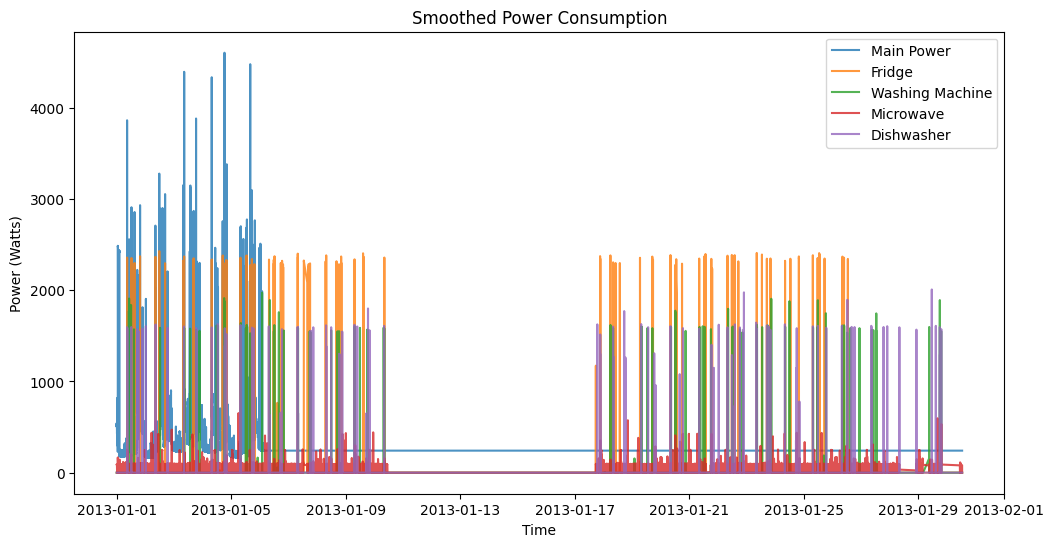

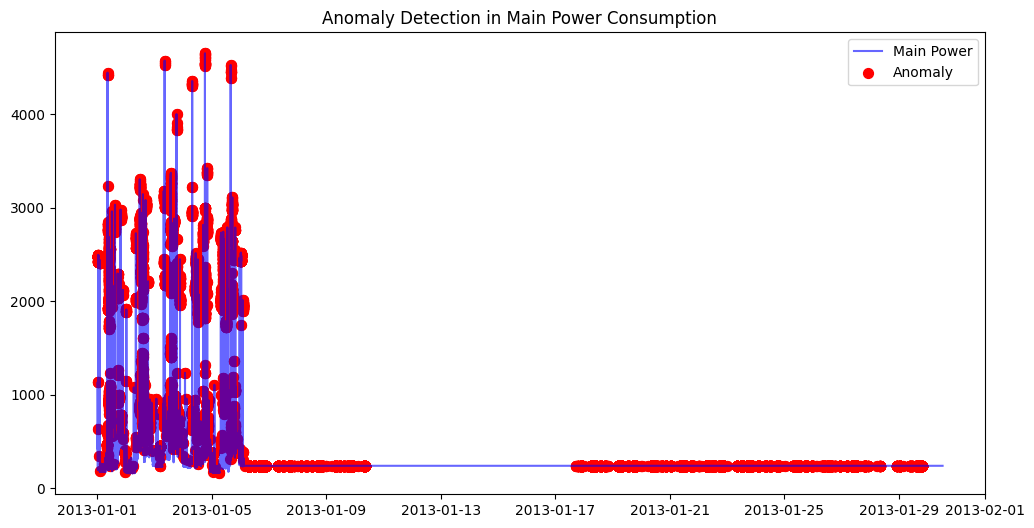

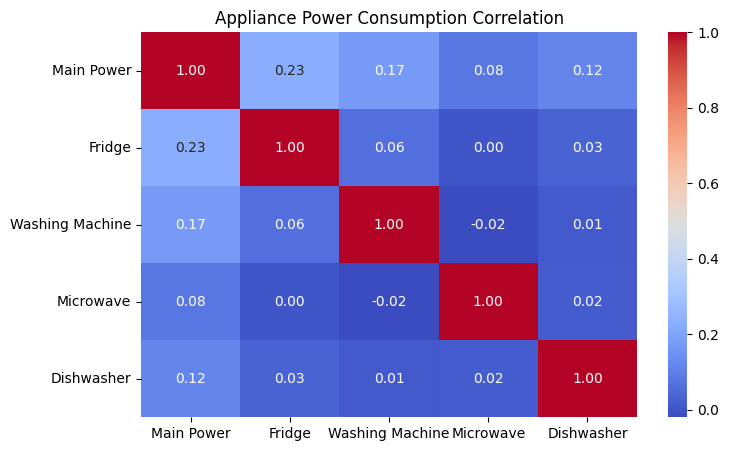

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

# Load Data
df = pd.read_csv("/Users/kjain/Project/house1_january2013_some_appliances.csv", parse_dates=['timestamp'])

# Fill missing values (forward-fill method)
df.fillna(method='ffill', inplace=True)

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# --- Time-Series Plot ---
plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column, alpha=0.7)
plt.legend()
plt.title("Power Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Power (Watts)")
plt.xticks(rotation=45)
plt.show()

# --- Rolling Mean for Smoothing ---
df_rolling = df.rolling(window=10).mean()

plt.figure(figsize=(12, 6))
for column in df_rolling.columns:
    plt.plot(df_rolling.index, df_rolling[column], label=column, alpha=0.8)
plt.legend()
plt.title("Smoothed Power Consumption")
plt.xlabel("Time")
plt.ylabel("Power (Watts)")
plt.show()

# --- Anomaly Detection using Isolation Forest ---
model = IsolationForest(contamination=0.05, random_state=42)
df["anomaly"] = model.fit_predict(df.fillna(0))

# Plot anomalies in Main Power
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Main Power"], label="Main Power", color='blue', alpha=0.6)
plt.scatter(df.index[df["anomaly"] == -1], df["Main Power"][df["anomaly"] == -1], 
            color='red', label="Anomaly", s=50)
plt.legend()
plt.title("Anomaly Detection in Main Power Consumption")
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(8, 5))
sns.heatmap(df.drop(columns=["anomaly"]).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Appliance Power Consumption Correlation")
plt.show()


/var/folders/sj/1c1l30xn36dgw92bwyf1rn_w0000gp/T/ipykernel_1534/2179911614.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('1T').mean()  # '1T' means 1 minute
/var/folders/sj/1c1l30xn36dgw92bwyf1rn_w0000gp/T/ipykernel_1534/2179911614.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled = df_resampled.fillna(method='ffill')  # Forward fill missing values


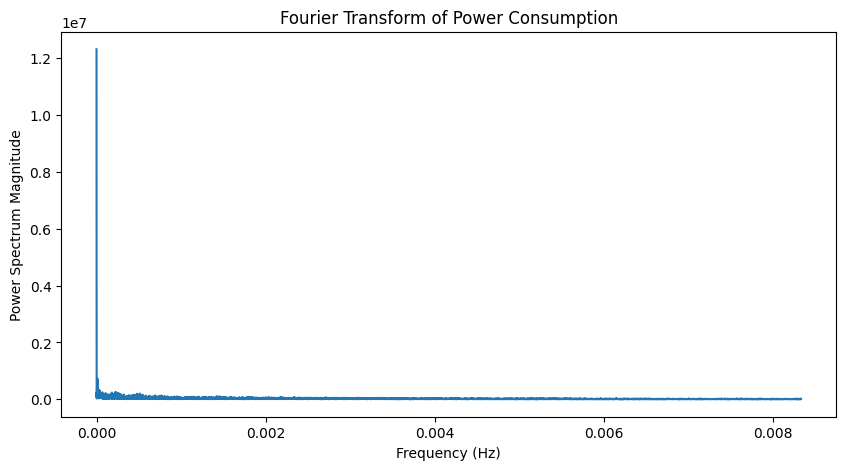

Dominant Period: inf seconds


/var/folders/sj/1c1l30xn36dgw92bwyf1rn_w0000gp/T/ipykernel_1534/2179911614.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  dominant_period = 1 / dominant_freq  # Convert to time domain


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Load dataset
df = pd.read_csv("house1_january2013_some_appliances.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

# Resample data to a uniform interval (e.g., 1 minute)
df_resampled = df.resample('1T').mean()  # '1T' means 1 minute
df_resampled = df_resampled.fillna(method='ffill')  # Forward fill missing values

# Select the column to analyze (e.g., 'Main Power')
signal = df_resampled["Main Power"].values

# Compute FFT
N = len(signal)  # Number of data points
T = 60  # Sampling interval in seconds (1 minute)
freqs = fftfreq(N, T)  # Frequency bins
fft_values = fft(signal)  # Compute FFT

# Get power spectrum (magnitude)
power_spectrum = np.abs(fft_values)

# Plot the power spectrum
plt.figure(figsize=(10, 5))
plt.plot(freqs[:N//2], power_spectrum[:N//2])  # Only positive frequencies
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectrum Magnitude")
plt.title("Fourier Transform of Power Consumption")
plt.show()

# Get dominant period
dominant_freq = freqs[np.argmax(power_spectrum[1:N//2])]  # Ignore DC component (index 0)
dominant_period = 1 / dominant_freq  # Convert to time domain

print(f"Dominant Period: {dominant_period:.2f} seconds")
